In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from torch.distributions import MultivariateNormal
import torchvision

from nflib.flow_function import *
from nflib.flow_model import *
from nflib.transform import *
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
np.random.seed(1)
torch.manual_seed(1)
opt= {}
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    opt['device']= torch.device('cuda:0')
    opt['if_cuda']=True
else:
    opt['device']= torch.device('cpu')
    opt['if_cuda']=False


In [2]:
# construct a model
dim=1024
s=32
flows = [DownSampling(),
         IncompressibleCNN(4),PermuteRandom(4),
         IncompressibleCNN(4),PermuteRandom(4),
         IncompressibleCNN(4),
         DownSampling(),
         IncompressibleCNN(16),PermuteRandom(16),
         IncompressibleCNN(16),PermuteRandom(16),
         IncompressibleCNN(16),
         Flatten([16,int(s/4),int(s/4)]),
         AffineHalfFlow(dim, parity=0),
         AffineHalfFlow(dim, parity=1)
        ]
model = FASpreadNormalizingFlowModel(flows, dim ).to(opt['device'])


In [3]:
def train_sample(n=100):
    v=np.random.rand(n,1)
    images=(np.zeros((n,1024))*v).reshape(n,32,32)
    images[:,13:19,13:19]=np.repeat(v, 36, axis=1).reshape(n,6,6)
    return torch.from_numpy(images).view(n,1,32,32).type(torch.float)

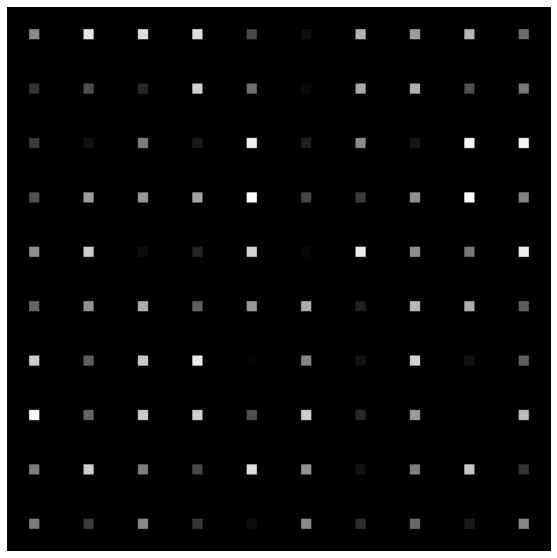

In [4]:
def fake_show_many(image,s,number_sqrt):
    
    canvas_recon = np.empty((s * number_sqrt, s * number_sqrt))
    count=0
    for i in range(number_sqrt):
        for j in range(number_sqrt):
            canvas_recon[i * s:(i + 1) * s, j * s:(j + 1) * s] = \
            image[count].reshape([s, s])
            count+=1
    plt.rcParams["axes.grid"] = False
    plt.figure(figsize=(number_sqrt, number_sqrt))
    plt.axis('off')
    plt.imshow(canvas_recon, origin="upper", cmap="gray")
    plt.show()
    
a=train_sample()
fake_show_many(a,s,10)

number of params:  1168572


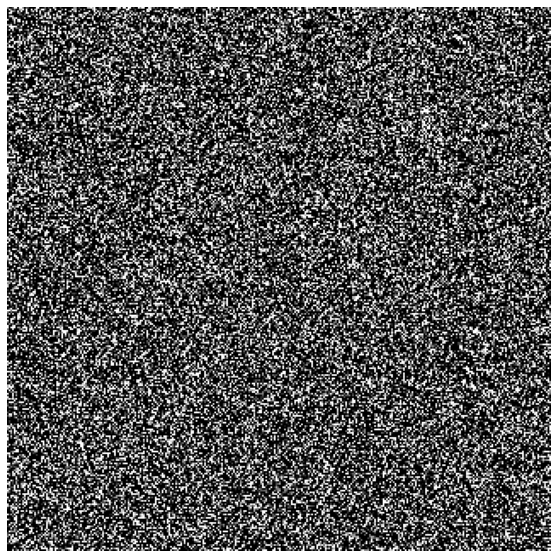

959.4820556640625


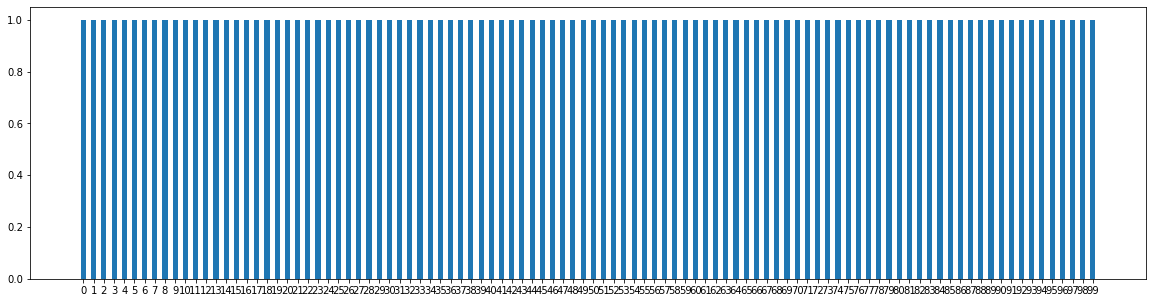

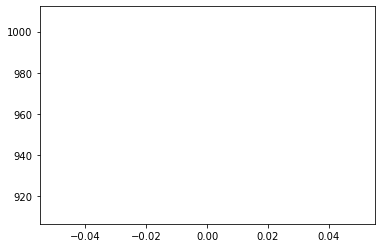

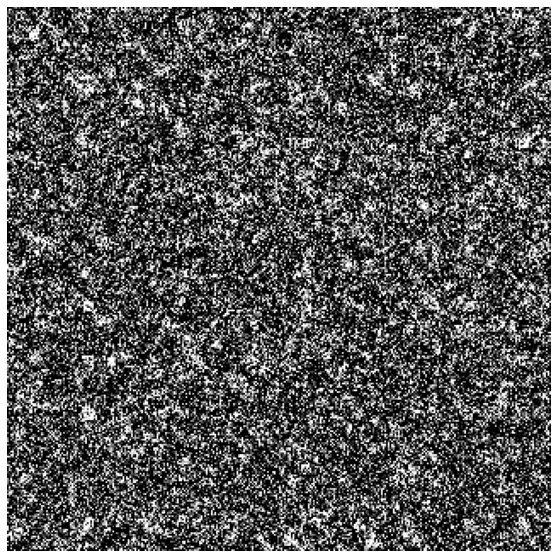

559.9188842773438


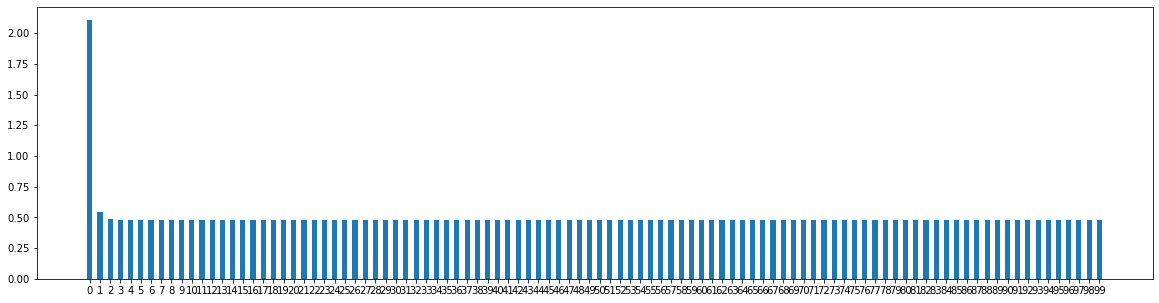

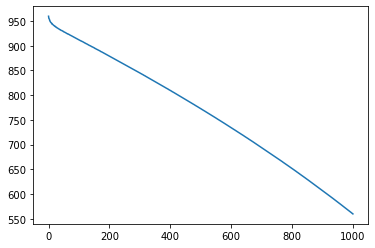

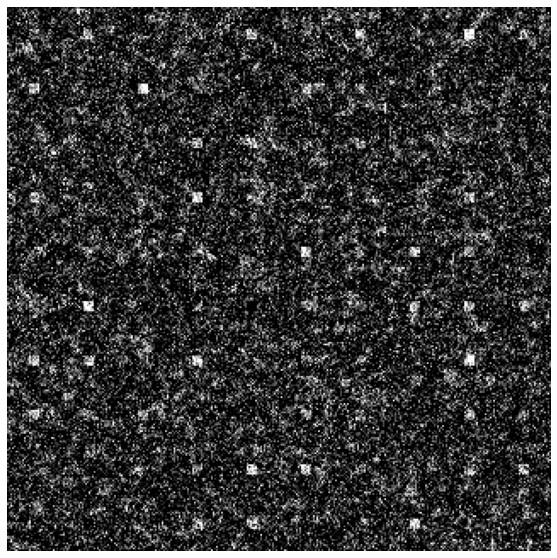

-208.6239776611328


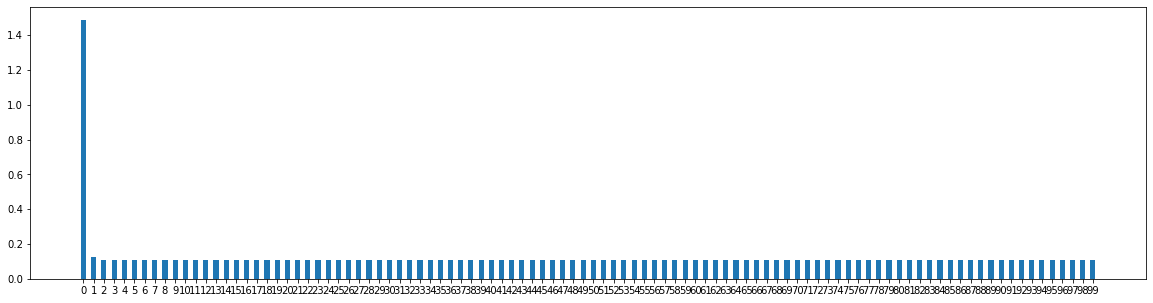

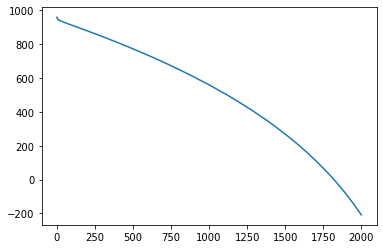

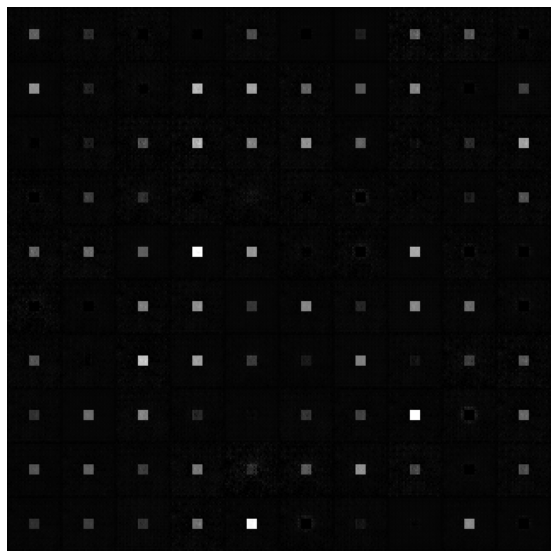

-3753.656494140625


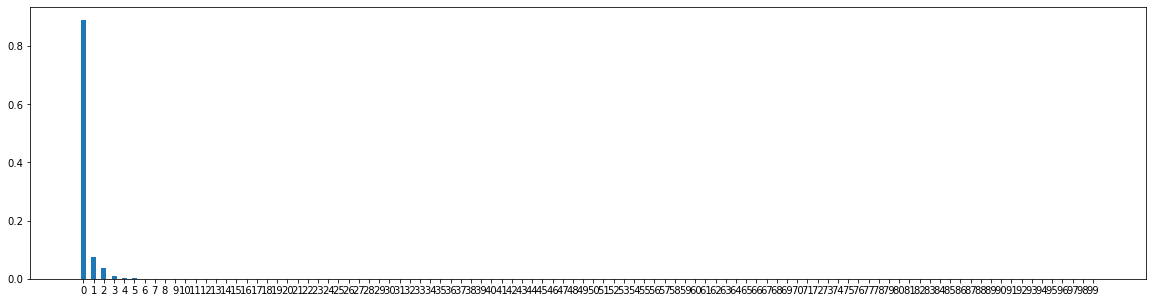

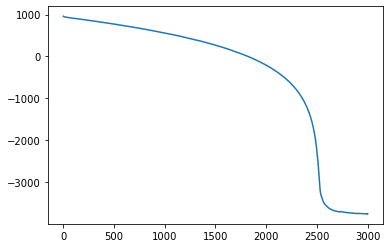

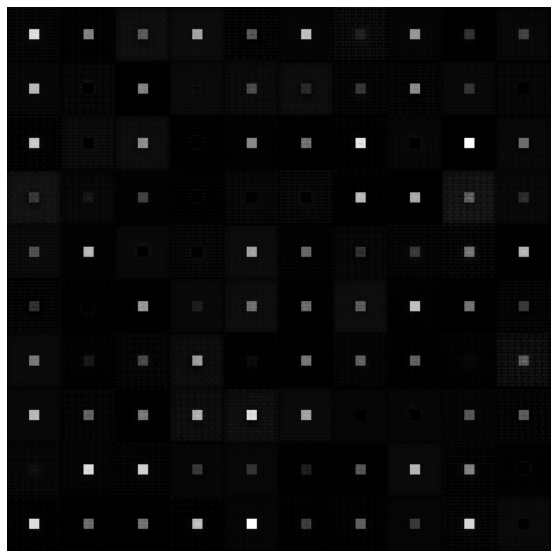

-3757.693115234375


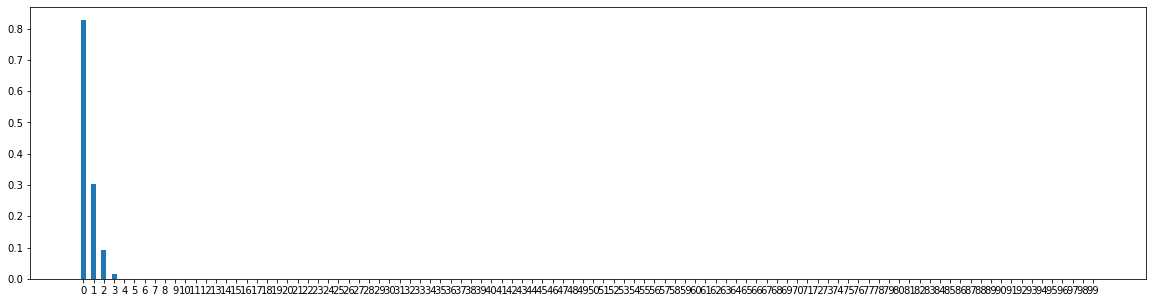

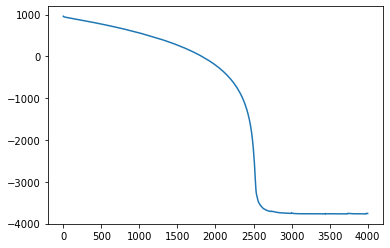

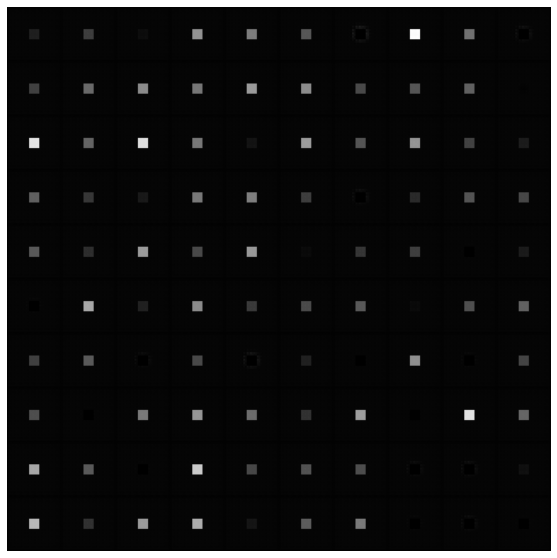

-3768.875


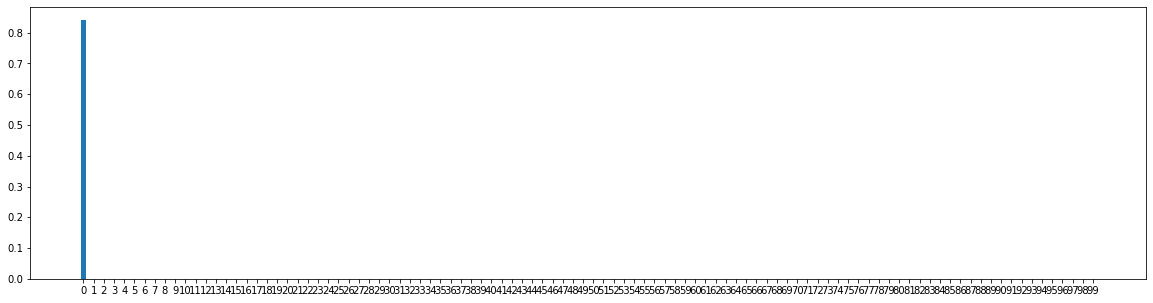

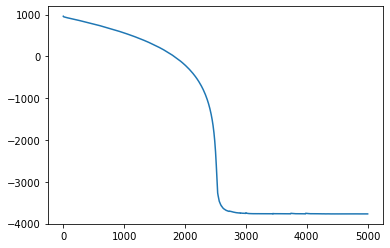

KeyboardInterrupt: 

In [5]:
s_dim=32
model.train()
loss_list=[]
lr=3e-4
optimizer = optim.Adam(model.parameters(), lr, weight_decay=0.5) 
print("number of params: ", sum(p.numel() for p in model.parameters()))
s_std=0.01
for k in range(50000):
    model.train()
    batch_data=train_sample()
    zs, prior_logprob, log_det = model(batch_data.to(opt['device']),s_std)
    logprob = prior_logprob + log_det
    loss = -torch.mean(logprob)

    model.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    if k % 1000 == 0:
        model.eval()
        model_samples,_ = model.backward(torch.randn(100,dim).to(opt['device'])@model.A.t())
        model_samples=model_samples[-1].detach().cpu().numpy()
        fake_show_many(np.clip(model_samples,0.,1.),s_dim,10)
        plt.show()
        print(loss.item())
        
        with torch.no_grad():
            cov=(model.A@model.A.t())
            u,s,v=np.linalg.svd(cov.cpu().numpy())
            plt.figure(figsize=(20,5))
            plt.bar([str(i) for i in range(0,100)], s[0:100],width=0.5)
            plt.show()

        plt.plot(loss_list)
        plt.show()

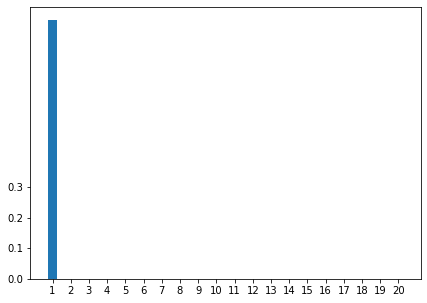

In [9]:
with torch.no_grad():
    cov=(model.A@model.A.t())
    u,s,v=np.linalg.svd(cov.cpu().numpy())
    plt.figure(figsize=(7,5))
    plt.yticks([0,0.1,0.2,0.3])
#     plt.ylim(-0.0,1.7)
    plt.bar([str(i+1) for i in range(0,20)], s[0:20],width=0.5)
    plt.show()

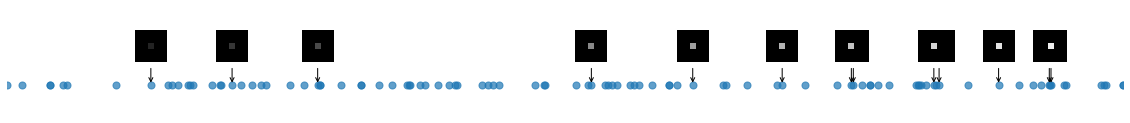

In [12]:
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

x=train_sample()
zs_true, prior_logprob, log_det = model(x.to(opt['device']),0.01)
zs_true=zs_true[-1].cpu().detach().numpy()
cov=(model.A@model.A.t()).cpu().detach().numpy()
u,s,v=np.linalg.svd(cov)
zs_proj=zs_true@u[0:1].transpose()

fig, ax = plt.subplots(figsize=(20,2))
y_value=np.zeros(100)
plt.scatter(zs_proj[:, 0], y_value,s=50,alpha=0.7)
plt.ylim([-0.08,0.2])
plt.axis('off')
for i in [0,1,5,6,9,10,13,14,15,18,23,25,26]:
    imagebox = OffsetImage(x[i][0], zoom=1.0,cmap="gray")
    img = imagebox.get_children()[0]; 
    img.set_clim(vmin=0, vmax=1)
                        
    ab = AnnotationBbox(imagebox, (zs_proj[i, 0], 0.0),(zs_proj[i, 0], 0.1),frameon=False,arrowprops=dict(arrowstyle="->"))
    ax.add_artist(ab)
plt.margins(0)
plt.show()